In [ ]:
### Lab 1
# Nick Lucas Friesen

In [2]:
### Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


In [3]:
### Download and Prepare CIFAR-10 dataset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # transform to Tensors of normalized range [-1, 1]

batch_size = 4

traindata = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=2)

testdata = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


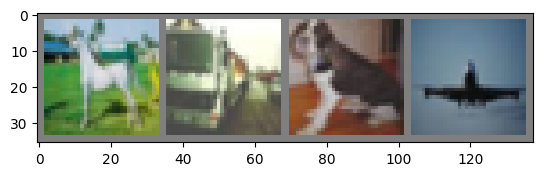

horse truck dog   plane


In [10]:
### Functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [4]:
### Simple CNN network for classifying images

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 2D convolution
        self.pool = nn.MaxPool2d(2, 2) # Pooling
        self.conv2 = nn.Conv2d(6, 12, 5) # Second 2D convolution
        self.fc1 = nn.Linear(12 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [13]:
### Init CNN and tensorboard

cnn = CNN()
writer = SummaryWriter()


In [14]:
### Loss and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0001) # switch learning here


In [15]:
### Train network

for epoch in range(10):
    train_loss = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # get the inputs; data is a list of [inputs, labels]
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {train_loss / 2000:.3f}')
            train_loss = 0.0

print('Finished Training')
writer.flush()


[1,  2000] loss: 2.081
[1,  4000] loss: 1.830
[1,  6000] loss: 1.717
[1,  8000] loss: 1.651
[1, 10000] loss: 1.610
[1, 12000] loss: 1.575
[2,  2000] loss: 1.555
[2,  4000] loss: 1.527
[2,  6000] loss: 1.505
[2,  8000] loss: 1.478
[2, 10000] loss: 1.464
[2, 12000] loss: 1.447
[3,  2000] loss: 1.441
[3,  4000] loss: 1.411
[3,  6000] loss: 1.384
[3,  8000] loss: 1.394
[3, 10000] loss: 1.379
[3, 12000] loss: 1.394
[4,  2000] loss: 1.346
[4,  4000] loss: 1.350
[4,  6000] loss: 1.318
[4,  8000] loss: 1.315
[4, 10000] loss: 1.319
[4, 12000] loss: 1.318
[5,  2000] loss: 1.280
[5,  4000] loss: 1.268
[5,  6000] loss: 1.262
[5,  8000] loss: 1.271
[5, 10000] loss: 1.265
[5, 12000] loss: 1.251
[6,  2000] loss: 1.214
[6,  4000] loss: 1.228
[6,  6000] loss: 1.225
[6,  8000] loss: 1.224
[6, 10000] loss: 1.222
[6, 12000] loss: 1.183
[7,  2000] loss: 1.186
[7,  4000] loss: 1.166
[7,  6000] loss: 1.192
[7,  8000] loss: 1.183
[7, 10000] loss: 1.173
[7, 12000] loss: 1.155
[8,  2000] loss: 1.134
[8,  4000] 

In [12]:
### Close Tensorboard

writer.close()


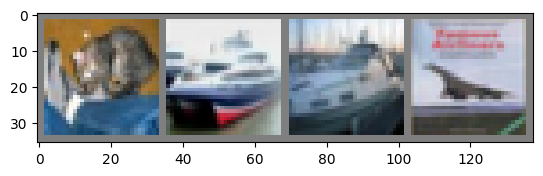

GroundTruth:  cat   ship  ship  plane
Predicted:  dog   ship  ship  ship 
Accuracy of the network on the 10000 test images: 22 %


In [11]:
### Test network

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

outputs = cnn(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
